<div style='background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 4px; padding: 15px; margin: 10px 0; border-left: 4px solid #f39c12;'>
<h3 style='color: #856404; margin-top: 0;'>⚠️ EXECUTION WARNING</h3>
<p style='color: #856404; margin-bottom: 0;'><strong>This notebook may not execute properly in the current environment.</strong></p>
<p style='color: #856404; margin-bottom: 0;'>Some cells may have failed during automated testing. Please review the notebook content and test manually before use.</p>
<p style='color: #856404; margin-bottom: 0; font-size: 0.9em;'><em>Generated during CI/CD pipeline - some outputs may be incomplete or missing.</em></p>
</div>


![STScI Logo](../../../_static/stsci_header.png)

# Scaling Flux while using the Hubble Advanced Spectral Products Script 

### <span style="font-weight:normal">This Notebook is designed to walk you through handling input spectra with differing fluxes with the **Hubble Advanced Spectral Products (HASP)** co-add script.</span>

## Learning Goals: 

By the end of this tutorial, you will learn how to:
- Use `astroquery.mast` to download STIS data

- Determine whether the input data requires flux scaling

- Implement flux scaling and prepare the spectra for use with the co-add script

- Run the co-add script

- Examine the co-added output

- Repeat the process with COS data


## Table of Contents
**0. [Introduction](#introduction)**

**1. [Downloading HST Spectroscopic Data](#datadownload)**

\- 1.1 [Using `Astroquery` to Download STIS Data](#stisdownload)

**2. [Running the Co-add Script without scaling](#runscript)**

**3. [Checking input data for flux variance](#checkflux)**

\- 3.1 [Plot input spectra relative to each other to identify flux variations](#variance)

**4. [Scaling Input Data](#scaledata)**

\- 4.1 [Determine Scaling Factors](#scaling)

\- 4.2 [Rescaling the Data](#package)

\- 4.3 [Re-running the co-add Script](#rerunning)


<a id = introduction></a>
## 0. Introduction

The [Hubble Advanced Spectral Products (HASP)](https://github.com/spacetelescope/hasp) code is a script that co-adds spectra within programs. It currently is able to co-add data from the [Space Telescope Imaging Spectrograph (STIS)](https://www.stsci.edu/hst/instrumentation/stis) and the [Cosmic Origins Spectrograph (COS)](https://www.stsci.edu/hst/instrumentation/cos) instruments onboard the [Hubble Space Telescope (HST)](https://www.stsci.edu/hst). The [Hubble Spectroscopic Legacy Archive (HSLA)](https://archive.stsci.edu/missions-and-data/hst/hasp) uses this script to co-add these instruments’ data from the [The Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) archive to make high quality, wide wavelength UV spectra that is publicly available for the scientific community. These custom co-addition notebooks will instruct users on how produce their own co-adds in cases where the MAST archive data needs special processing or is rejected. 

The script first co-adds a program's observation set spectra for each grating, then it combines all gratings for the observation set. Finally, it co-adds the spectra of each observation set in the program to produce a fully co-added spectra for each target in a program. lease check out the [COS 2024-01 ISR](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/ISR2024-01.pdf) for more information about HASP.

In the process of co-adding data, the script will also check the flux of input data in each wavelength bin for a given mode against a first coadd that includes all of the input spectra. If the median flux of an input spectrum is lower than a given threshold against the co-add, it will be removed and the program iterates until no more spectra are rejected. This is to prevent data from failed observations from being co-added, but it will also impact sources  that are variable. Additionally for extended sources, the amount of light collected by the PSA on COS may be different from a STIS aperture, which could create flux offsets between gratings. Finally, some of the small apertures for STIS can be impacted by changes in observatory focus and create flux offsets. Similarly, extended sources that are observed at multiple orientations may have slight variations in flux. If a user's science case is not dependent on the accuracy of a dataset's absolute flux, scaling input spectra to be the same average or median flux may be desirable.

This notebook will go into depth about checking for variability in a set of data, scaling data to a common median flux, running the co-add script, and inspecting the output by plotting flux as a function of wavelength. This notebook assumes that the user has very little experience with Python but is already familiar with the basic usage of the co-add script; users who are more experienced and would just like to learn how to run and download the script can checkout the [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook in this repository. Less experienced users should first run the [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial) notebook in this repository.

### Imports

We will be using multiple libraries to retrieve and analyze data. We will use: 
* `Path.pathlib` to create product and data directories 
* `astroquery.mast Observations` to download COS and STIS data
* `shutil` to perform directory and file operations
* `os` to interact with the operating system
* `astropy.io fits` to work with FITS files
* `matplotlib.pyplot` to plot abutted spectra
* `glob` to work with multiple files in our directories
* `numpy` to calculate median scale factors

We recommend creating a HASP-specific `conda` environment when co-adding spectra. You can checkout our [Setup.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/Setup) notebook to create such an environment. Alternatively, you can also download the required dependencies to run this notebook with the terminal command: 

`pip install -r requirements.txt`

This will download the dependencies that are necessary to run this current notebook. Let's import all of our packages that we will use in this notebook and print our `conda` environment by running the next cell:

In [1]:
import os
from pathlib import Path
from astroquery.mast import Observations
import shutil
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

print("Currently active conda environment:", os.environ.get("CONDA_PREFIX"))

Currently active conda environment: /home/runner/micromamba/envs/ci-env


<a id = datadownload></a>
## 1. Downloading HST Spectroscopic Data

We will download one STIS dataset using `Observations` from the Python module `astroquery.mast`.

<a id = stisdownload></a>
### 1.1 Using `Astroquery` to Download STIS Data

We will be downloading STIS data for the white dwarf [G191-B2b](http://simbad.cds.unistra.fr/simbad/sim-basic?Ident=G191-B2b); this is an object that is commonly used as a standard. We will specifically download data from Program 8345, which has observations of G191-B2b using the gratings `E140M` and `E230M`.

We can start with setting up our directory structure and querying the MAST database for the STIS program's data. This will give us a list of *all* observations for the program.

In [2]:
# Creating the data download directories for STIS
stis_data_dir = Path("./stis_data/")

# Creating the products directory to hold the output
stis_products_dir = Path("./stis_products/")

# Creating the scaled data directories STIS
stis_scaled_data_dir = Path("./stis_scaled_data/")

# Creating the scaled products directory to hold the output
stis_scaled_products_dir = Path("./stis_scaled_products/")

# If the directory doesn't exist, then create it
stis_data_dir.mkdir(exist_ok=True)
stis_products_dir.mkdir(exist_ok=True)
stis_scaled_data_dir.mkdir(exist_ok=True)
stis_scaled_products_dir.mkdir(exist_ok=True)

In [3]:
# Conduct the query
g191_query = Observations.query_criteria(
    proposal_id=8435,
    target_name="G191B2B",
    dataproduct_type="SPECTRUM"
)

Now that we've queried the observations for Program 8345's data, we can get a list that contains the associated data products for the observations from the query. More details on downloading data are available in the [CoaddTutorial.ipynb](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP/CoaddTutorial).

In [4]:
g191_products = Observations.get_product_list(
    g191_query
)

Observations.download_products(
    g191_products,
    download_dir=str(stis_data_dir),
    productSubGroupDescription=["X1D", "SX1"]
)

INFO: 5 of 11 products were duplicates. Only returning 6 unique product(s). [astroquery.mast.utils]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str55,str8,object,object
stis_data/mastDownload/HST/o5jy03010/o5jy03010_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o5jy03020/o5jy03020_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o5jy03030/o5jy03030_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o5jy04010/o5jy04010_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o5jy04020/o5jy04020_x1d.fits,COMPLETE,None,None
stis_data/mastDownload/HST/o5jy04030/o5jy04030_x1d.fits,COMPLETE,None,None


To be able to run the HASP script, we now must move all STIS files to a single directory. When we download data using `astroquery`, it creates a directory `mastDownload/HST`. All sub-folders within that are each different dataset ID.

In [5]:
try:
    # The path to all obs_id folders
    mast_path = f"{stis_data_dir}/mastDownload/HST/"

    # Check if mastDownload exists
    if not os.path.exists(mast_path):
        print(f"Directory {mast_path} doesn't exist.")

    # Getting a list of all obs_id folders. Each folder contains the FITS files
    obs_id_dirs = os.listdir(mast_path)

    # Iterating through sub-folders to change the path of each FITS file
    for obs_id in obs_id_dirs:
        # This is the path to each obs_id folder
        obs_id_path = os.path.join(mast_path, obs_id)

        # Getting list of FITS files in /mastDownload/HST/<obs_id> folder
        stis_files = glob.glob(obs_id_path + "/*fits")

        # Iterating through each of these files to change their path individually
        # We will be moving them to /stis_data
        for file in stis_files:
            file_path = Path(file)
            new_path = stis_data_dir / file_path.name
            shutil.move(file, new_path)

    # Now we can remove the mastDownload directory
    if os.path.exists(mast_path):
        shutil.rmtree(f"{stis_data_dir}/mastDownload/")

except Exception as e:
    print(f"An error occurred: {e}")

<a id = runscript></a>
## 2. Running the Co-add Script

Now that we've downloaded the G191B2B STIS data, we can run the co-add script. 

In the terminal, run the script by using the next cell's command. Make sure that you are in the `hasp-env` `conda` environment that we created at the beginning of the notebook. It is also possible to run the command directly from the cell below.

The `-i` parameter is the input directory (i.e, where the FITS files are located). `-o` is the directory that will contain the newly created co-added products. Note that if you want to exclude certain data files from the co-add, you can just remove them from the input directory.

In this case, the code determines that there are significant differences between the `E140M` spectra and rejects any spectra fainter than a certain threshold. The details of the threshold calculation are given in [ISR COS 2024-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/cos/documentation/instrument-science-reports-isrs/_documents/ISR2024-01.pdf). In the output text below, this is identified by phrases such as:

`Removing file ./stis_data/o5jy03030_x1d.fits from product.`

Dataset `o5jy04030_x1d.fits` is removed from the co-add. However, small STIS echelle apertures often are impacted by changes in observatory focus and do not reflect intrinsic changes to the object. Thus, we can scale the input spectra to a common flux level and improve signal-to-noise.

In [6]:
!swrapper -i ./stis_data -o ./stis_products

HASP version 1.2.5
Ullyses version 4.1.0


Creating list of unique modes from these files:


./stis_data/o5jy03010_x1d.fits G191B2B STIS FUV-MAMA E140M 0.1X0.03 0 8435 (8435, '03')
./stis_data/o5jy03020_x1d.fits G191B2B STIS FUV-MAMA E140M 0.1X0.03 0 8435 (8435, '03')
./stis_data/o5jy03030_x1d.fits G191B2B STIS FUV-MAMA E140M 0.1X0.03 0 8435 (8435, '03')
./stis_data/o5jy04010_x1d.fits G191B2B STIS NUV-MAMA E230M 0.1X0.03 0 8435 (8435, '04')
./stis_data/o5jy04020_x1d.fits G191B2B STIS NUV-MAMA E230M 0.1X0.03 0 8435 (8435, '04')
./stis_data/o5jy04030_x1d.fits G191B2B STIS NUV-MAMA E230M 0.1X0.03 0 8435 (8435, '04')
Looping over visits
Processing product (8435, '03')
Targets in visit (8435, '03'): ['G191B2B']
Processing target G191B2B in visit (8435, '03')
Processing grating STIS/E140M
Importing files ['./stis_data/o5jy03010_x1d.fits', './stis_data/o5jy03020_x1d.fits', './stis_data/o5jy03030_x1d.fits']
Processing file ./stis_data/o5jy03010_x1d.fits
Processing file ./stis_data/o5jy03020_x1d.fits
Processing file ./stis_data/o5jy03030_x1d.fits


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/ullyses/coadd.py:550: RuntimeWarning: divide by zero encountered in divide
  weighted_gross = weight_function[self.weighting_method](gross, exptime, net/flux)


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #86 of segment o5jy03jxq from file ./stis_data/o5jy03010_x1d.fits


No good pixels for order #86 of segment o5jy03k0q from file ./stis_data/o5jy03020_x1d.fits


No good pixels for order #86 of segment o5jy03k1q from file ./stis_data/o5jy03030_x1d.fits


Order 107 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -52.196539306689644
Removing file ./stis_data/o5jy03030_x1d.fits from product
Order 109 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -51.51203851087941
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 110 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -53.458026063810884
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 111 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -55.17910690306585
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 112 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -55.488447095672
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 113 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has

Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #86 of segment o5jy03jxq from file ./stis_data/o5jy03010_x1d.fits


No good pixels for order #86 of segment o5jy03k0q from file ./stis_data/o5jy03020_x1d.fits


./stis_products/hst_8435_stis_g191b2b_e140m_o5jy03_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_8435_stis_g191b2b_e140m_o5jy03_cspec.fits
Only 1 grating to abut, skipping abutment
Processing product (8435, '04')
Targets in visit (8435, '04'): ['G191B2B']
Processing target G191B2B in visit (8435, '04')
Processing grating STIS/E230M
Importing files ['./stis_data/o5jy04010_x1d.fits', './stis_data/o5jy04020_x1d.fits', './stis_data/o5jy04030_x1d.fits']
Processing file ./stis_data/o5jy04010_x1d.fits
Processing file ./stis_data/o5jy04020_x1d.fits
Processing file ./stis_data/o5jy04030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #66 of segment o5jy04saq from file ./stis_data/o5jy04010_x1d.fits


No good pixels for order #66 of segment o5jy04sdq from file ./stis_data/o5jy04020_x1d.fits


No good pixels for order #66 of segment o5jy04seq from file ./stis_data/o5jy04030_x1d.fits


./stis_products/hst_8435_stis_g191b2b_e230m_o5jy04_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_8435_stis_g191b2b_e230m_o5jy04_cspec.fits
Only 1 grating to abut, skipping abutment
Looping over proposals
Processing product 8435
Targets in proposal 8435: ['G191B2B']
Processing target G191B2B in proposal 8435
Processing grating STIS/E140M
Importing files ['./stis_data/o5jy03010_x1d.fits', './stis_data/o5jy03020_x1d.fits', './stis_data/o5jy03030_x1d.fits']
Processing file ./stis_data/o5jy03010_x1d.fits


Processing file ./stis_data/o5jy03020_x1d.fits
Processing file ./stis_data/o5jy03030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #86 of segment o5jy03jxq from file ./stis_data/o5jy03010_x1d.fits


No good pixels for order #86 of segment o5jy03k0q from file ./stis_data/o5jy03020_x1d.fits


No good pixels for order #86 of segment o5jy03k1q from file ./stis_data/o5jy03030_x1d.fits


Order 107 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -52.196539306689644
Removing file ./stis_data/o5jy03030_x1d.fits from product
Order 109 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -51.51203851087941
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 110 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -53.458026063810884
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 111 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -55.17910690306585
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 112 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has scaled median = -55.488447095672
File ./stis_data/o5jy03030_x1d.fits already selected for removal from product
Order 113 from segment o5jy03k1q in file ./stis_data/o5jy03030_x1d.fits has

Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #86 of segment o5jy03jxq from file ./stis_data/o5jy03010_x1d.fits


No good pixels for order #86 of segment o5jy03k0q from file ./stis_data/o5jy03020_x1d.fits


./stis_products/hst_8435_stis_g191b2b_e140m_o5jy_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_8435_stis_g191b2b_e140m_o5jy_cspec.fits
Processing grating STIS/E230M
Importing files ['./stis_data/o5jy04010_x1d.fits', './stis_data/o5jy04020_x1d.fits', './stis_data/o5jy04030_x1d.fits']
Processing file ./stis_data/o5jy04010_x1d.fits
Processing file ./stis_data/o5jy04020_x1d.fits
Processing file ./stis_data/o5jy04030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #66 of segment o5jy04saq from file ./stis_data/o5jy04010_x1d.fits


No good pixels for order #66 of segment o5jy04sdq from file ./stis_data/o5jy04020_x1d.fits


No good pixels for order #66 of segment o5jy04seq from file ./stis_data/o5jy04030_x1d.fits


./stis_products/hst_8435_stis_g191b2b_e230m_o5jy_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_8435_stis_g191b2b_e230m_o5jy_cspec.fits
Making a product from these gratings
STIS/E140M 1141.6-1727.2 (Actual: 1140.4-1709.4)
STIS/E230M 1606.7-3119.2 (Actual: 2277.5-3071.8)
Maximum wavelength of STIS/E140M tweaked to 1709.3950499028301
Minimum wavelength of STIS/E230M tweaked to 2277.522932816718
Maximum wavelength of STIS/E230M tweaked to 3071.793300151605
Starting at the short wavelength end with grating STIS/E140M
Truncating current grating at 1709.3950499028301
Abutting STIS/E230M product to current result
With a transition wavelength of 2277.522932816718
Truncating current grating at 3071.793300151605
./stis_products/hst_8435_stis_g191b2b_e140m-e230m_o5jy_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_products/hst_8435_stis_g191b2b_e140m-e230m_o5jy_cspec.fits


We can now change the flux scaling for the input spectra and re-run the co-add code!

<a id = checkflux></a>
## 3. Checking Input Spectra for Flux Variance

With the newly co-added files in the `./stis_products/output` directory, we can begin to inspect the data and determine why some of the data was excluded.

Let's first enter the `./stis_products` directory to look at the files. Currently, the script outputs abutted products for a single program and its constituent visits, a file for each grating and a joining of all gratings. For the tutorial, `hst_8435_stis_g191b2b_e140m_o5jy_cspec.fits` is the `E140M` co-add product we will use to compare to our spectra.

**Note: Check that this is the correct filename for the co-add; it is possible that the HASP script has been updated.**

In [7]:
coadd = "hst_8435_stis_g191b2b_e140m_o5jy_cspec.fits"

<a id = variance></a>
### 3.1 Plot Input Spectra Relative to Each to Other to Search for Variability

We will create a plot of flux as a function of wavelength using `matplotlib.pyplot` to compare the input spectra to the co-add. We will see significant scaling offsets.

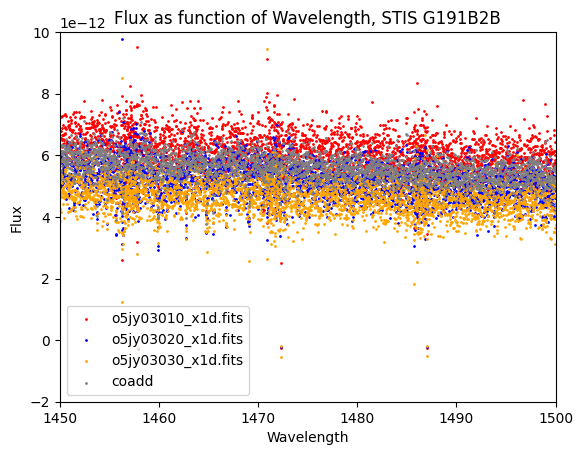

In [8]:
# Define the paths and filenames for our investigation
files = ["o5jy03010_x1d.fits", "o5jy03020_x1d.fits", "o5jy03030_x1d.fits"]

# Getting the co-add data
coadd_hdul = fits.open(f"{stis_products_dir}/{coadd}")
coadd_data = coadd_hdul[1].data

# Getting the wavelength and flux data for the abutted file
wavelength = coadd_data["WAVELENGTH"]
flux = coadd_data["FLUX"]

# Colors for plotting
colors = ["red", "blue", "orange"]

# Getting the input spectra
for i, filename in enumerate(files):
    gd191_hdul = fits.open(f"{stis_data_dir}/{filename}")
    gd191_x1d = gd191_hdul[1].data

    # Getting the flux and wavelength data
    wave_x1d = gd191_x1d["WAVELENGTH"]
    flux_x1d = gd191_x1d["FLUX"]

    # Plotting flux vs wavelength for each X1D in our investigation
    plt.scatter(wave_x1d, flux_x1d,
                s=1,
                label=filename,
                color=colors[i])
    
    gd191_hdul.close()

# Plot the coadd for comparison
plt.scatter(wavelength, flux,
            s=1,
            label='coadd',
            color='grey')

# Formatting the plot
plt.title("Flux as function of Wavelength, STIS G191B2B")
plt.xlabel("Wavelength")
plt.ylabel("Flux")

plt.ylim(-2e-12, 1e-11)
plt.xlim(1450, 1500)

plt.legend()

# Saving the figure to the ./stis_products_dir
plt.savefig(f"{stis_products_dir}/flux_vs_wavelength.png")

# Showing the plot below
plt.show()

The co-add is grey, while the individual spectra are red, blue, and orange, respectively. The dataset that was removed (orange points) from the co-add is systematically lower than the co-add. We next calculate the scaling between the three input spectra and assume that the spectrum with the highest flux is most correct.

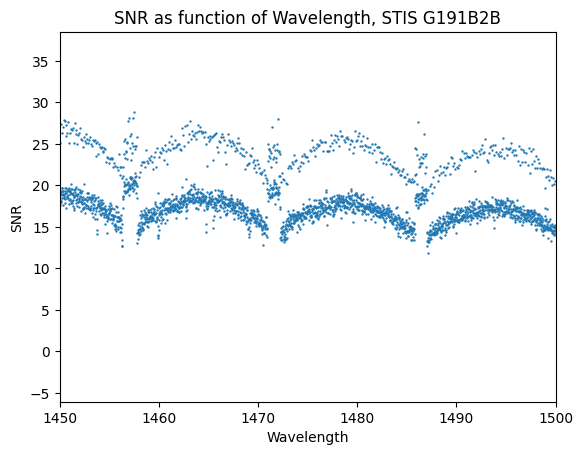

In [9]:
# Checking the SNR of co-add for comparison to improved custom co-add later
SNR = coadd_data["SNR"]

plt.scatter(wavelength, SNR,
            s=0.5)

# Formatting the plot by adding titles
plt.title("SNR as function of Wavelength, STIS G191B2B")
plt.xlabel("Wavelength")
plt.ylabel("SNR")

plt.xlim(1450, 1500)

plt.savefig(f"{stis_products_dir}/snr_vs_wavelength_prescaled.png")

plt.show()

# Closing coadd HDUL
coadd_hdul.close()

For this particular dataset, a slight difference between the native wavelength bin size of the input co-adds and the output bins results in some bins receiving multiple measures of the flux which increase the SNR above other bins.

<a id = scaleflux></a>
## 4. Scaling Input Data

We now determine scaling factors to apply to our input data. Using the scaling factors we determine, we re-scale the input spectra, save them as new input files, and re-run the co-add code on the modified datasets, improving the overall SNR.

<a id = scaling></a>
### 4.1 Determine Scaling Factors
First we calculate the scale factors needed by taking the median of each spectrum, then using the brightest spectrum median as the normalizing factor.

In [10]:
# Getting the fluxes of the files we're interested in
hdul_010 = fits.open(f"{stis_data_dir}/o5jy03010_x1d.fits")
flux_010 = hdul_010[1].data["FLUX"]

hdul_020 = fits.open(f"{stis_data_dir}/o5jy03020_x1d.fits")
flux_020 = hdul_020[1].data["FLUX"]

hdul_030 = fits.open(f"{stis_data_dir}/o5jy03030_x1d.fits")
flux_030 = hdul_030[1].data["FLUX"]


med_spec_010 = np.median(flux_010)
med_spec_020 = np.median(flux_020)
med_spec_030 = np.median(flux_030)

# # Printing the median flux for each X1D file:
print(f"The median flux for file o5jy03010_x1d.fits is: {str(med_spec_010)}")
print(f"The median flux for file o5jy03020_x1d.fits is: {str(med_spec_020)}")
print(f"The median flux for file o5jy03030_x1d.fits is: {str(med_spec_030)}\n")

print("The brightest spectrum is file o5jy03010_x1d.fits")

hdul_010.close()
hdul_020.close()
hdul_030.close()

The median flux for file o5jy03010_x1d.fits is: 7.332183e-12
The median flux for file o5jy03020_x1d.fits is: 6.1427196e-12
The median flux for file o5jy03030_x1d.fits is: 5.5390805e-12

The brightest spectrum is file o5jy03010_x1d.fits


We can see that the first spectrum (`o5jy03010_x1d.fits`) is the brightest of the three, so we will use it as the normalizing factor.

In [11]:
scale_factor = [1.0,
                med_spec_010 / med_spec_020,
                med_spec_010 / med_spec_030]

<a id = package></a>
### 4.2 Rescaling the Data 
Now that the input files for `E140M` have been rescaled, we create new input files and re-run the co-add script

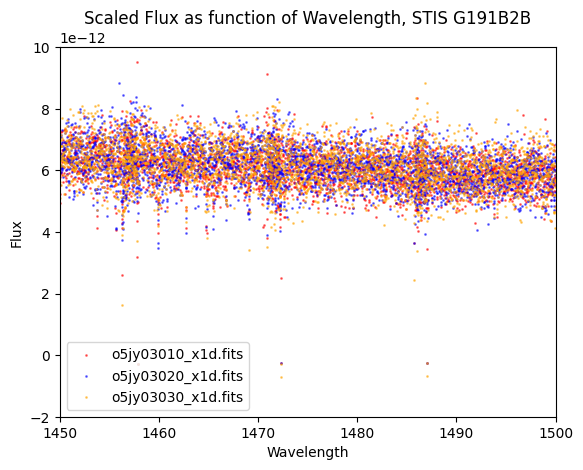

In [12]:
for i, filename in enumerate(files):
    g191_hdul = fits.open(f"{stis_data_dir}/{filename}")
    g191_data = g191_hdul[1].data

    # Getting the flux and wavelength data for the X1D files in our investigation
    flux = g191_data["FLUX"]
    wavelength = g191_data["WAVELENGTH"]

    # Multiplying the current file's flux by the approproiate scaling factor
    g191_data["FLUX"] = flux * scale_factor[i]

    # Writing this scaled data to data directory
    g191_hdul.writeto(f"{stis_scaled_data_dir}/{filename}",
                      overwrite=True)

    # Plotting this flux vs wavelength
    plt.scatter(wavelength, flux,
                s=1,
                alpha=0.5,
                label=filename,
                color=colors[i])
    
    g191_hdul.close()

# Adding formatting
plt.title("Scaled Flux as function of Wavelength, STIS G191B2B")
plt.xlabel("Wavelength")
plt.ylabel("Flux")

plt.ylim(-2e-12, 1e-11)
plt.xlim(1450, 1500)

plt.legend()

plt.savefig("./stis_scaled_data/scaled_flux_vs_wavelength.png")

plt.show()

<a id = rerunning></a>
### 4.3 Re-running the co-add Script
Now that the input files for `E140M` have been rescaled, we can re-run the co-add script:

In [13]:
!swrapper -i ./stis_scaled_data -o ./stis_scaled_products

HASP version 1.2.5
Ullyses version 4.1.0


Creating list of unique modes from these files:
./stis_scaled_data/o5jy03010_x1d.fits G191B2B STIS FUV-MAMA E140M 0.1X0.03 0 8435 (8435, '03')
./stis_scaled_data/o5jy03020_x1d.fits G191B2B STIS FUV-MAMA E140M 0.1X0.03 0 8435 (8435, '03')
./stis_scaled_data/o5jy03030_x1d.fits G191B2B STIS FUV-MAMA E140M 0.1X0.03 0 8435 (8435, '03')
Looping over visits
Processing product (8435, '03')
Targets in visit (8435, '03'): ['G191B2B']
Processing target G191B2B in visit (8435, '03')
Processing grating STIS/E140M
Importing files ['./stis_scaled_data/o5jy03010_x1d.fits', './stis_scaled_data/o5jy03020_x1d.fits', './stis_scaled_data/o5jy03030_x1d.fits']
Processing file ./stis_scaled_data/o5jy03010_x1d.fits
Processing file ./stis_scaled_data/o5jy03020_x1d.fits
Processing file ./stis_scaled_data/o5jy03030_x1d.fits


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/ullyses/coadd.py:550: RuntimeWarning: divide by zero encountered in divide
  weighted_gross = weight_function[self.weighting_method](gross, exptime, net/flux)


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #86 of segment o5jy03jxq from file ./stis_scaled_data/o5jy03010_x1d.fits


No good pixels for order #86 of segment o5jy03k0q from file ./stis_scaled_data/o5jy03020_x1d.fits


No good pixels for order #86 of segment o5jy03k1q from file ./stis_scaled_data/o5jy03030_x1d.fits


./stis_scaled_products/hst_8435_stis_g191b2b_e140m_o5jy03_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_scaled_products/hst_8435_stis_g191b2b_e140m_o5jy03_cspec.fits
Only 1 grating to abut, skipping abutment
Looping over proposals
Processing product 8435
Targets in proposal 8435: ['G191B2B']
Processing target G191B2B in proposal 8435
Processing grating STIS/E140M
Importing files ['./stis_scaled_data/o5jy03010_x1d.fits', './stis_scaled_data/o5jy03020_x1d.fits', './stis_scaled_data/o5jy03030_x1d.fits']
Processing file ./stis_scaled_data/o5jy03010_x1d.fits
Processing file ./stis_scaled_data/o5jy03020_x1d.fits
Processing file ./stis_scaled_data/o5jy03030_x1d.fits


Using a maximum SNR of 20.0 in flux-based filtering
No good pixels for order #86 of segment o5jy03jxq from file ./stis_scaled_data/o5jy03010_x1d.fits


No good pixels for order #86 of segment o5jy03k0q from file ./stis_scaled_data/o5jy03020_x1d.fits


No good pixels for order #86 of segment o5jy03k1q from file ./stis_scaled_data/o5jy03030_x1d.fits


./stis_scaled_products/hst_8435_stis_g191b2b_e140m_o5jy_cspec.fits already exists and overwrite=False, skipping write
   Wrote ./stis_scaled_products/hst_8435_stis_g191b2b_e140m_o5jy_cspec.fits
Only 1 grating to abut, skipping abutment


We see in the output above that no spectra were rejected from the co-add script. Further, we have increased the SNR of the final co-add spectrum:

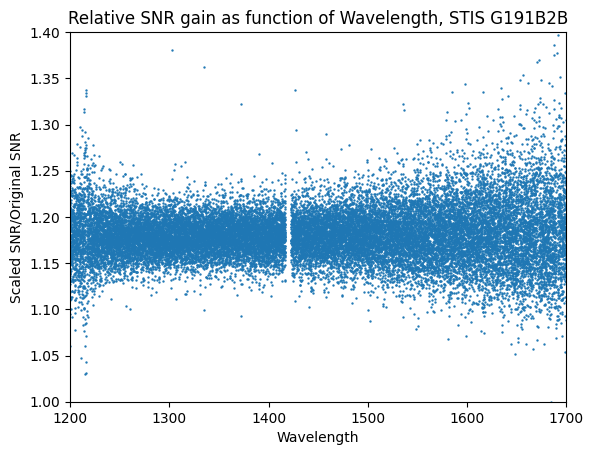

In [14]:
# Getting the co-add data
gd191_scaled_hdul = fits.open(f"{stis_scaled_products_dir}/{coadd}")
gd191_scaled = gd191_scaled_hdul[1].data

# Getting the wavelength and flux data for the scaled file
w_scaled = gd191_scaled["WAVELENGTH"]
f_scaled = gd191_scaled["FLUX"]
SNR_scaled = gd191_scaled["SNR"]

# Remove elements where original SNR = 0
SNR_scaled_nonzero = SNR_scaled[np.nonzero(SNR)]
SNR_nonzero = SNR[np.nonzero(SNR)]

SNR_scaled = SNR_scaled_nonzero / SNR_nonzero

w_scaled_nonzero = w_scaled[np.nonzero(SNR)]

# Finally we check the SNR of the co-add for comparison to the original co-add
plt.scatter(w_scaled_nonzero, SNR_scaled,
            s=0.5)

# Formatting the plot
plt.title("Relative SNR gain as function of Wavelength, STIS G191B2B")
plt.xlabel("Wavelength")
plt.ylabel("Scaled SNR/Original SNR")

plt.xlim(1200, 1700)
plt.ylim(1, 1.4)

plt.savefig(f"{stis_scaled_products_dir}/scaled_rel_snr_vs_wavelength.png")

plt.show()

gd191_scaled_hdul.close()

# Congrats on completing the notebook!

### There are more tutorial notebooks for custom co-addition cases in [this notebooks repo](https://github.com/spacetelescope/hst_notebooks/tree/main/notebooks/HASP), check them out!

## About this Notebook
**Authors:** John Debes (debes@stsci.edu), Sierra Gomez (sigomez@stsci.edu)

**Updated on:** 01/29/2024

*This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*


## Citations

If you use `astropy`, `astroquery`, `numpy`, or `matplotlib`, for published research, please cite the authors. Follow these links for more information about citations:

* [Citing `astropy`](https://docs.astropy.org/en/stable/index.html)

* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)

* [Citing `numpy`](https://numpy.org/citing-numpy/)
<hr>
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 